# Part 2 : Building the modular network

### Overview

This Notebook continues where Part 2 left. We work with the original paper once again, but this rebuilding the modular network.

This Notebook builds the network in a more efficient way.

### Chapters


### 0. Plot configuration


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (12, 7)


## 1. Building the network


In [2]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads'
dt = 0.1

nest.SetKernelStatus(
    {"local_num_threads": n, "resolution": dt, "overwrite_files": True}
)

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  7 2023 05:58:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Apr 13 13:58:34 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


### 1b. Building the modular network


What we now want to do is to take the same number of _total_ neurons as before, but change their topology by rewiring connections. Something like the follow figure:

<img src="./../img/neural_columns.png" width="600">

The paper uses a recursive method for splitting the random network into submodules, where

- inhibitory synapses are always rewired within the module
- excitatory synapses are rewired within with the probability $R_{ex}$,

The paper also provides a formula for computing inter-modular connection probabilities:

Splitting a module into $m$ submodules of equal size at each level, the connection density between the modules of the $i$ th level is:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e006.gif" width="500">

where $i = 1,…,l$, if a network is rewiring into a l-level HMN. The connection density within each unit of the network, that is, the l-level module, is

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e007.gif" width="500">


## 2. Configure input stimulations


Papers on criticality uses different types of stimulations. Here, we'll use two types of stimulation:

1. All-but-sharp: All modules, one node, continous stimulation.
2. Few-but-wide: Few modules, most nodes, continous stimulation.

TODO

3. Resolve chaos: Spark the network with 180 Hz for 50 ms.


In [3]:
import numpy as np

len_submodule = 625
expected_global_spike_rate = 50


def get_all_but_sharp_stimulation(stop=10_000, rate_hz=1):
    """
    1. All modules, one node, continous stimulation.
    """

    all_but_sharp_stimulation = {
        "poisson_config": {
            "rate": rate_hz * 1000,
            "stop": stop,
        },
        "stimulate_module_ids": np.arange(1, 17),
        "stimulate_module_ratio": 0.01,
    }
    return all_but_sharp_stimulation


def get_few_but_wide_stimulation(stop=10_000, rate_hz=5):
    """
    2. Few modules, most nodes, continous stimulation.
    """

    all_submodule_ids = np.arange(1, 17)
    size = 4

    few_but_wide_stimulation = {
        "poisson_config": {
            "rate": rate_hz * 1000,
            "stop": stop,
        },
        "stimulate_module_ids": np.random.choice(
            all_submodule_ids, size=size, replace=False
        ),
        "stimulate_module_ratio": 0.5,
    }
    return few_but_wide_stimulation

## 3. Replicate paper results


### 3.2 Variation of Firing Patterns


Let's now explore this parameter space of synaptic weights, notice that our parameters are x10 the values on the graph:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_m/fncom-05-00030-g002.jpg" width="600">


**The IS zone**

As the raster plot shows, although the Poisson nose only runs between 0 - 200 ms, the network activity persists until the end of the simulation - 1000ms. Indicating that we have found the delicate balance of E / I strength


**all-but-sharp stimulation**

Using static synapses.
Apr 13 13:58:34 SimulationManager::set_status [Info]: 
    Temporal resolutio
n changed from 0.1 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.
Stimulation scheme: {'poisson_config': {'rate': 1000, 'stop': 10000}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.01}

Apr 13 13:58:37 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.

Apr 13 13:58:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 3000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 13 13:59:09 SimulationManager::run [Info]: 
    Simulation finished.


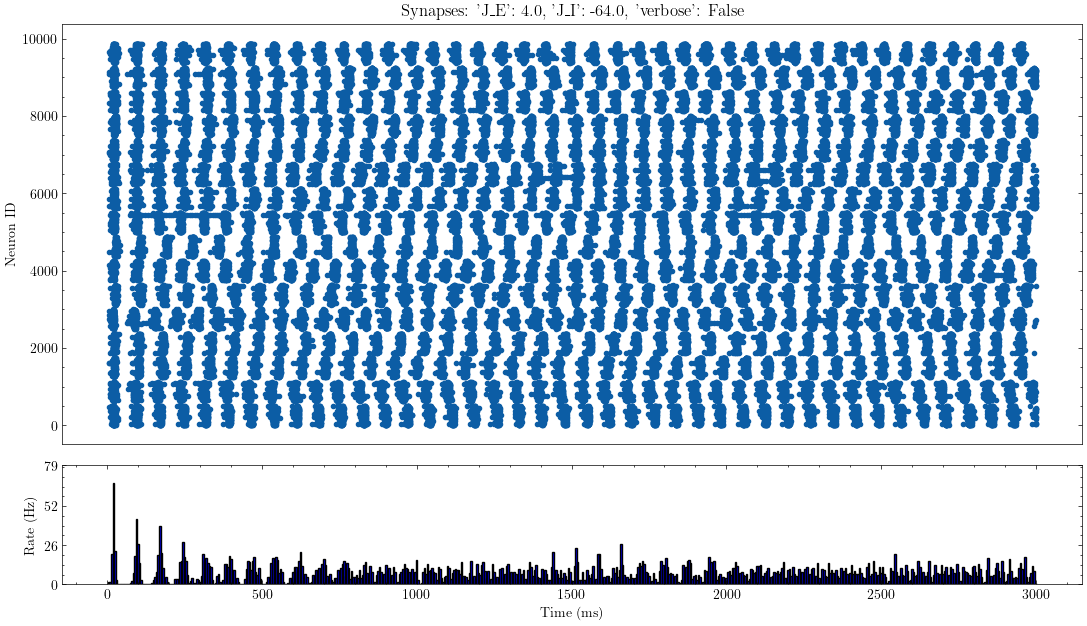

In [4]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

STIMULATION_SCHEME = get_all_but_sharp_stimulation()

#####################
strength = 8

params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 3_000

hmm_network_1 = HMN_network(**params_1)
hmm_network_1.build()
hmm_network_1.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_1.plot(title=f"Synapses: {params_1}")


Apr 13 13:59:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Using static synapses.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 13 13:59:15 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 5000, 'stop': 200}, 'stimulate_module_ids': array([13,  1,  5, 15]), 'stimulate_module_ratio': 0.5}
Apr 13 13:59:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 13 13:59:27 SimulationManager::run [Info]: 
    Simulation finished.



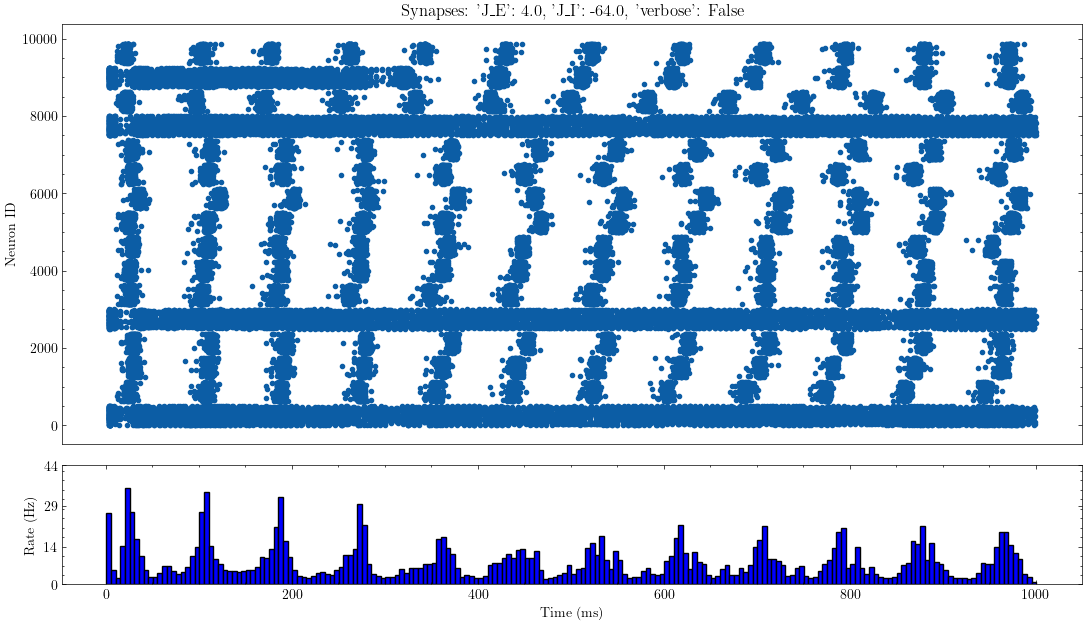

In [5]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=200)

#####################
strength = 8

params_2 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 1_000

hmm_network_2 = HMN_network(**params_2)
hmm_network_2.build()
hmm_network_2.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_2.plot(title=f"Synapses: {params_1}")

**The IT zone**

As the raster plot shows, the network activity dies when the Poisson generator stops.



Apr 13 13:59:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1Using static synapses.
 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 13 13:59:30 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 5000, 'stop': 200}, 'stimulate_module_ids': array([16, 12,  2, 14]), 'stimulate_module_ratio': 0.5}

Apr 13 13:59:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 13 13:59:39 SimulationManager::run [Info]: 
    Simulation finished.


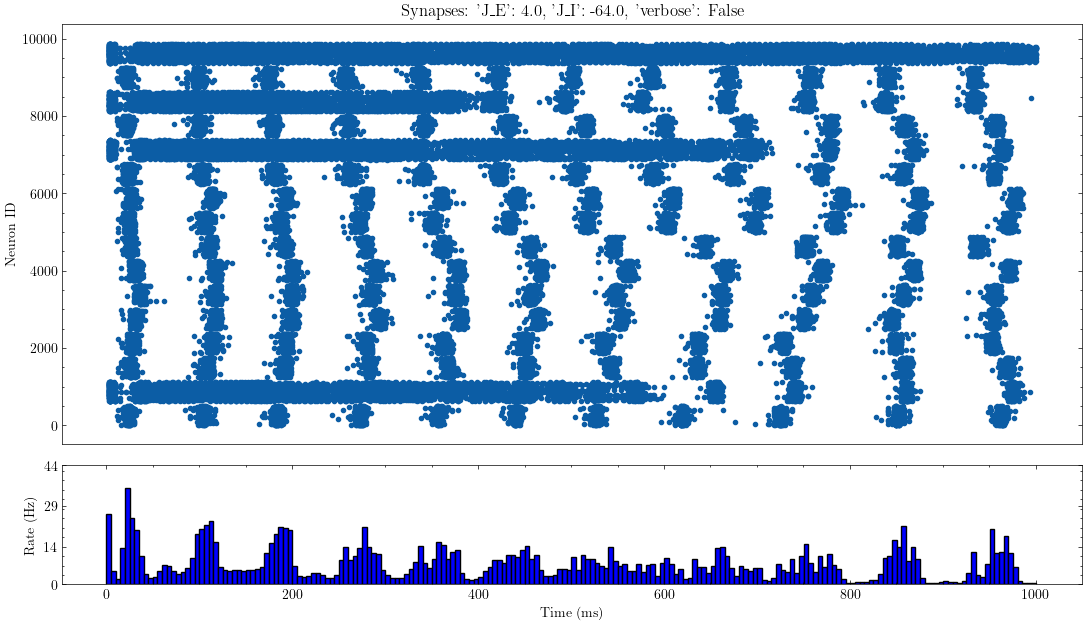

In [6]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=200)

#####################
strength = 8

params_3 = {
    "J_E": 0.1 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 1_000

hmm_network_3 = HMN_network(**params_2)
hmm_network_3.build()
hmm_network_3.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_3.plot(title=f"Synapses: {params_1}")

### 3.3 Critical Behavior in HMNs


The paper investigated whether the activity of the networks has properties of criticality.

They analyzed the

- distribution of the size of each activity of a module, and
- the length ls of the silent interval between two active periods (Figure 2B).

Activity size is measured as the number of spikes fired in an active period.


Using static synapses.

Apr 13 13:59:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 13 13:59:41 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 1000, 'stop': 10000}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.01}

Apr 13 13:59:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 2000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 13 14:00:01 SimulationManager::run [Info]: 
    Simulation finished.


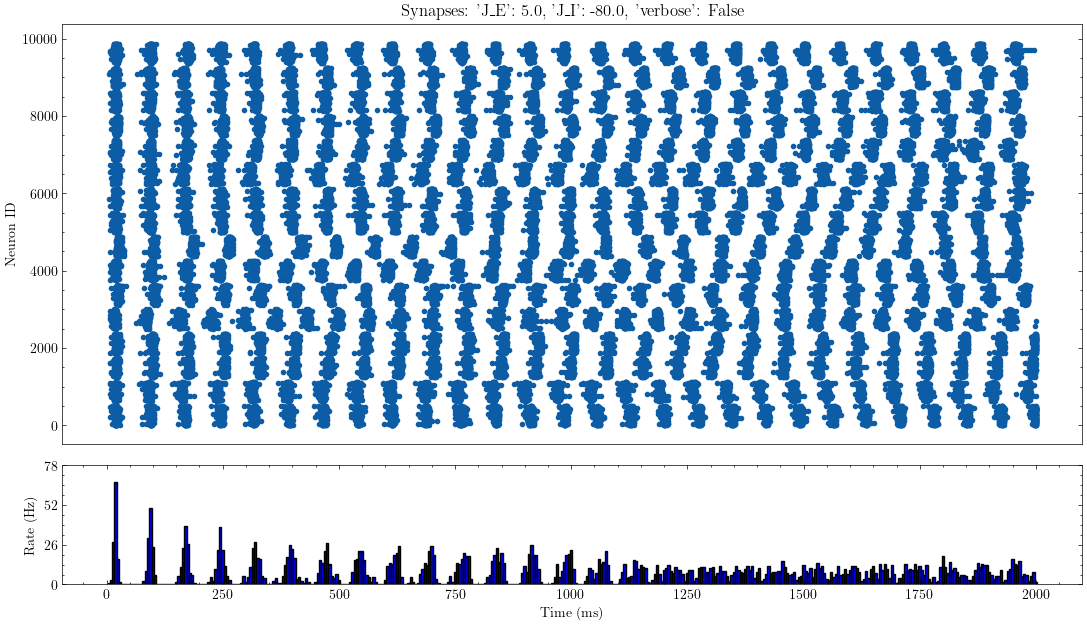

In [7]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

STIMULATION_SCHEME = get_all_but_sharp_stimulation()

#####################
strength = 10

params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 2_000

hmm_network_1 = HMN_network(**params_1)
hmm_network_1.build()
hmm_network_1.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_1.plot(title=f"Synapses: {params_1}")

Parse spike events


In [8]:
import numpy as np
import pandas as pd


def get_silent_time_distribution(spike_events):
    df_spike_events = (
        pd.DataFrame(spike_events)
        .sort_values("times")
        .reset_index(drop=True)
        .query("times < 3000")
    )
    df_spike_events["times"] = df_spike_events["times"] * 10

    df_silent_time = (
        df_spike_events.assign(
            silent_time=df_spike_events["times"]
            - df_spike_events["times"].shift(periods=1)
        )
        .query("silent_time > 0.1 and silent_time < 50")
        .silent_time.round(4)
        .value_counts()
        .to_frame()
    )
    silent_time_distribution = df_silent_time.divide(df_silent_time.sum())
    return silent_time_distribution


def get_avalanche_size_distribution(spike_events, silent_threshold=0.2):
    allowed_deltas = np.arange(0, silent_threshold, 0.1)

    df_spike_events = (
        pd.DataFrame(spike_events).sort_values("times").reset_index(drop=True)
    )

    df_spike_events["in_avalanche"] = (
        (df_spike_events["times"].shift(-1) - df_spike_events["times"].shift(0))
        .round(3)
        .isin(allowed_deltas)
    )
    df_spike_events["avalanche_id"] = (
        ~df_spike_events["in_avalanche"]
    ).cumsum() * df_spike_events["in_avalanche"]

    df_avalanche_sizes = (
        df_spike_events.query("avalanche_id != 0")
        .groupby(["avalanche_id"])
        .size()
        .add(1)
        .value_counts()
        .to_frame("avalanche_sizes")
    )

    avalanche_size_distribution = df_avalanche_sizes.divide(df_avalanche_sizes.sum())
    return avalanche_size_distribution

Fit power law


In [9]:
def func_powerlaw(x, c, m):
    return c * x**m

Function to fit: c * x**m
Curve fit: c=0.93 +- 0.001, m=-4.66 +- 0.051
Parameter error: [0.00135805 0.05131058]


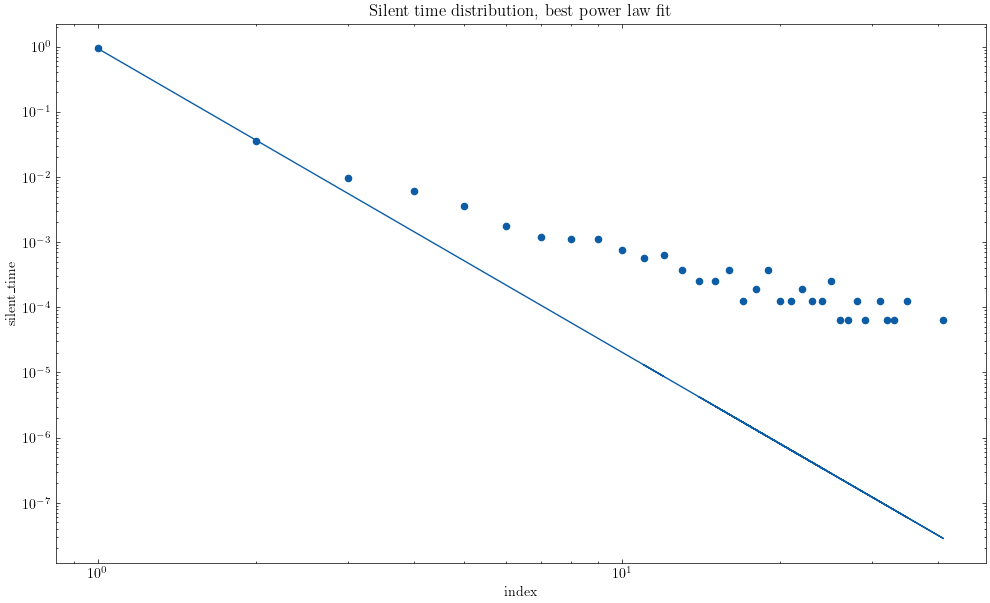

In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit


def fit_silent_period_to_power_distribution(spike_events):
    df_silent_time = get_silent_time_distribution(spike_events)

    X = df_silent_time.index
    y = df_silent_time["silent_time"]

    popt, pcov = curve_fit(func_powerlaw, X, y)
    perr = np.sqrt(np.diag(pcov))
    popt = np.round(popt, 2)
    plt.plot(X, func_powerlaw(X, *popt))

    print("Function to fit: c * x**m")
    print(
        f"Curve fit: c={popt[0]} +- {round(perr[0], 3)}, m={popt[1]} +- {round(perr[1], 3)}"
    )
    print(f"Parameter error: {perr}")

    return popt[:2]


def plot_silent_period_distribution(spike_events):
    df_silent_time = get_silent_time_distribution(spike_events)

    df_silent_time.reset_index().plot(
        logx=True,
        logy=True,
        kind="scatter",
        x="index",
        y="silent_time",
        title="Silent time distribution, best power law fit",
    )


spikes_E = hmm_network_1.spikes_E
spike_events = spikes_E.get("events")

plot_silent_period_distribution(spike_events)
c_length, m_length = fit_silent_period_to_power_distribution(spike_events)

Function to fit: c * x**m
Curve fit: c=0.72 +- 0.045, m=-1.5 +- 0.059
Parameter error: [0.04518267 0.0594139 ]


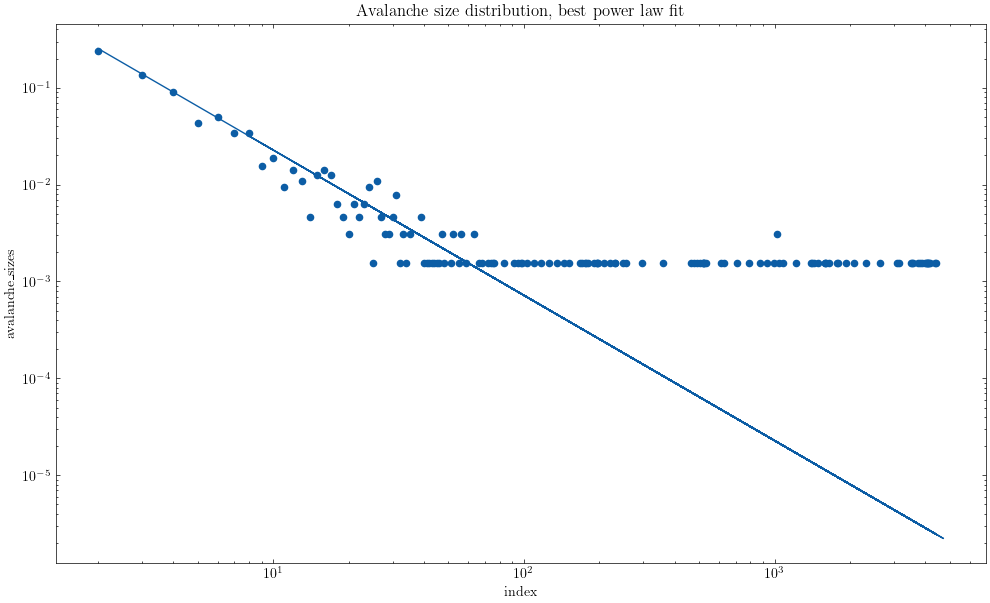

In [11]:
def fit_avalanche_sizes_to_power_distribution(spike_events, silent_threshold):
    df_avalanche_sizes = get_avalanche_size_distribution(spike_events, silent_threshold)

    X = df_avalanche_sizes.index
    y = df_avalanche_sizes["avalanche_sizes"]

    popt, pcov = curve_fit(func_powerlaw, X, y)
    perr = np.sqrt(np.diag(pcov))
    popt = np.round(popt, 2)
    plt.plot(X, func_powerlaw(X, *popt))

    print("Function to fit: c * x**m")
    print(
        f"Curve fit: c={popt[0]} +- {round(perr[0], 3)}, m={popt[1]} +- {round(perr[1], 3)}"
    )
    print(f"Parameter error: {perr}")

    return popt[:2]


def plot_avalanche_sizes_distribution(spike_events):
    df_avalanche_sizes = get_avalanche_size_distribution(spike_events)

    df_avalanche_sizes.reset_index().plot(
        logx=True,
        logy=True,
        kind="scatter",
        x="index",
        y="avalanche_sizes",
        title="Avalanche size distribution, best power law fit",
    )


plot_avalanche_sizes_distribution(spike_events)
c_activity, m_activity = fit_avalanche_sizes_to_power_distribution(
    spike_events, silent_threshold=0.4
)

The critical exponent of avalanche shapes: $\gamma = \frac{\kappa - 1}{\beta - 1} $


In [12]:
def compute_gamma(m_length, m_activity):
    return (m_length - 1) / (m_activity - 1)


gamma = compute_gamma(-m_length, -m_activity)

print(f"Gamma: {gamma}")

Gamma: 7.32


### 4. Exploring the depressive synapse network

Here, we initialize all inhibitory synapses to weight 0. We then let the system evolve

Using depressing synapses.

Apr 13 14:21:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 13 14:21:23 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.

Apr 13 14:21:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 13 14:21:43 SimulationManager::run [Info]: 
    Simulation finished.
Stimulation scheme: {'poisson_config': {'rate': 2000, 'stop': 10000}, 'stimulate_module_ids': array([10,  3, 14,  7]), 'stimulate_module_ratio': 0.5}


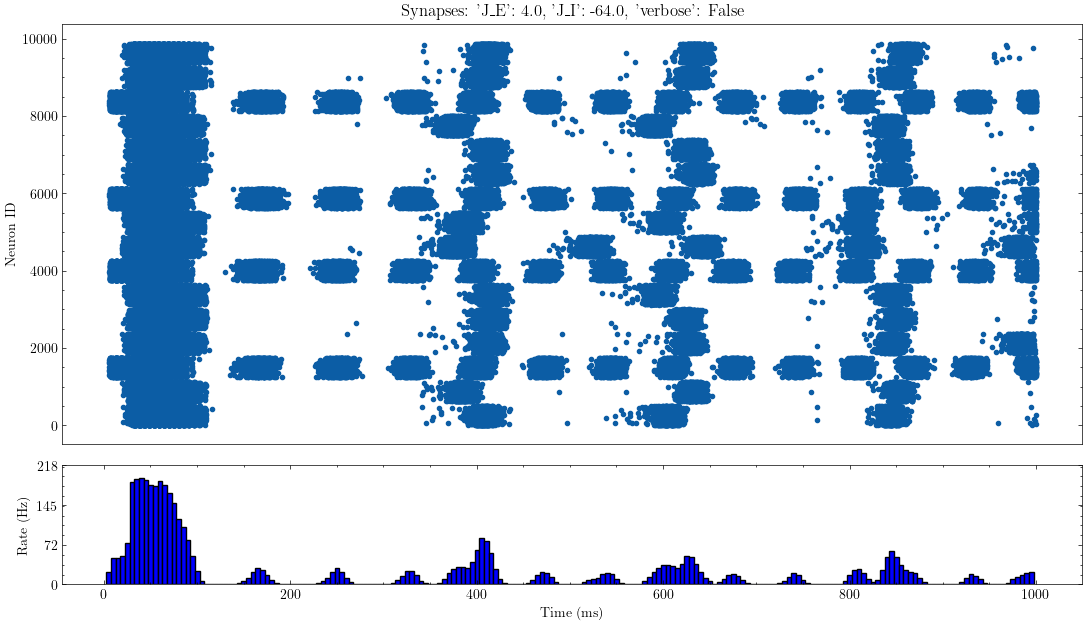

In [16]:
from classes.hmn_depressive_network import HMNDepressiveNetwork

nest.ResetKernel()

STIMULATION_SCHEME = get_few_but_wide_stimulation(rate_hz=2)

#####################
strength = 8

params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 1_000

hmm_network_dep_1 = HMNDepressiveNetwork(**params_1)
hmm_network_dep_1.build()
hmm_network_dep_1.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_dep_1.plot(title=f"Synapses: {params_1}")

Text(0.5, 1.0, 'Histogram of inhibitory synaptic weights')

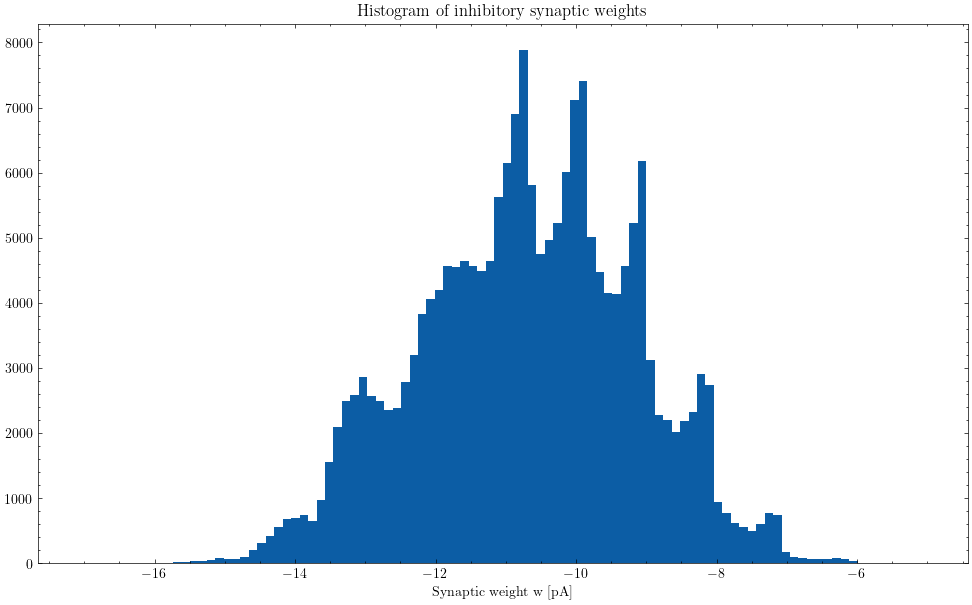

In [15]:
import pylab

nodes = hmm_network_dep_1.nodes

w = nest.GetStatus(
    nest.GetConnections(nodes[:10_000], synapse_model="inhibitory_synapse"),
    "weight",
)

# pylab.subplot(122)
_ = pylab.hist(w, bins=100)
pylab.xlabel("Synaptic weight w [pA]")
pylab.title("Histogram of inhibitory synaptic weights")

Using depressing synapses.

Apr 08 01:05:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 08 01:05:42 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
Stimulation scheme: {'poisson_config': {'rate': 1000, 'stop': 10000}, 'stimulate_module_ids': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'stimulate_module_ratio': 0.01}

Apr 08 01:05:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 6000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 08 01:07:03 SimulationManager::run [Info]: 
    Simulation finished.


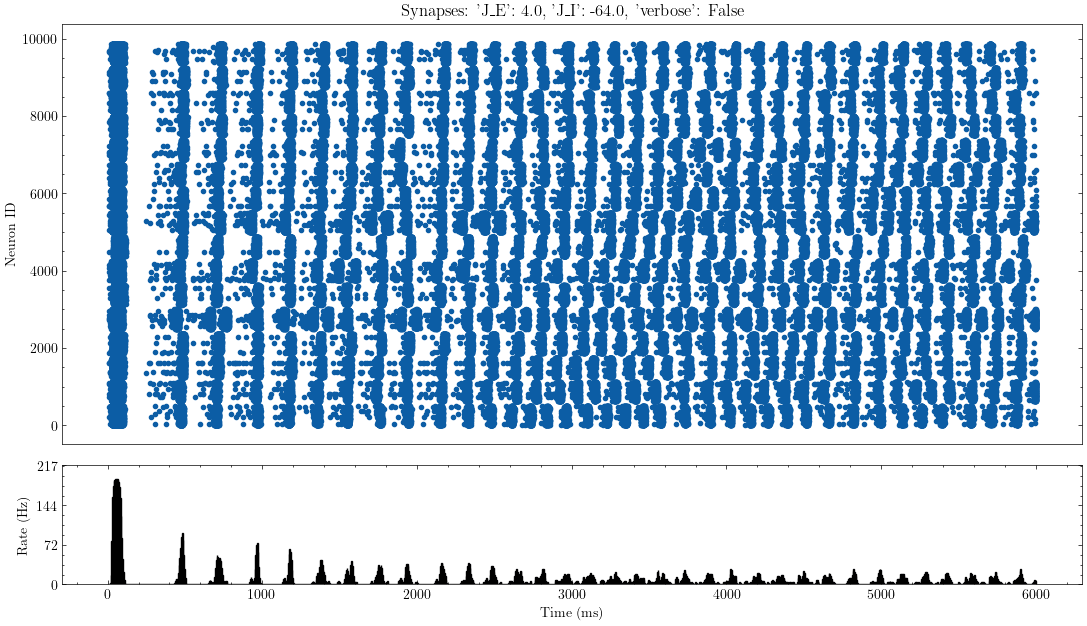

In [ ]:
from classes.hmn_depressive_network import HMNDepressiveNetwork

nest.ResetKernel()

STIMULATION_SCHEME = get_all_but_sharp_stimulation(rate_hz=1)

#####################
strength = 8

params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}

simtime = 6_000

hmm_network_dep_1 = HMNDepressiveNetwork(**params_1)
hmm_network_dep_1.build()
hmm_network_dep_1.simulate(
    simtime=simtime,
    poisson_config=STIMULATION_SCHEME["poisson_config"],
    stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
    stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
    record_module_ids=list(range(1, 17)),
    # record_module_ids=[4],
)
print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_dep_1.plot(title=f"Synapses: {params_1}")